In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd


mpl.rcParams['figure.dpi'] = 100

In [2]:
from utils.corpus import Corpus

corpus = Corpus(registry_path='utils/article_registry.json')
corpusList = corpus.get_documents_list()

Loading corpus. Num. of articles: 771


## Article types

In [36]:
data = []
for article in corpus.load_documents_from_registry(only_articles=False):
    data.append({
        'type': article.type,
        'year': int(article.date[:4])
    })

df = pd.DataFrame(data)

<AxesSubplot:xlabel='0', ylabel='type'>

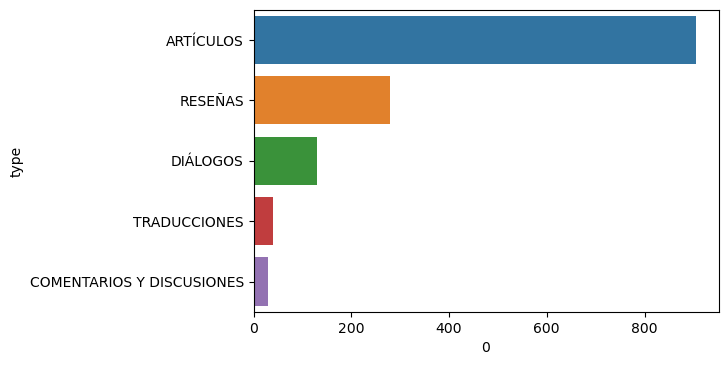

In [70]:
sns.barplot(data = df.value_counts(['type'])[:5].reset_index(), y = 'type', x = 0, orient='h')

## Orthographic correction

In [3]:
data = []
for article in corpusList:
    if article.format == "pdf":
        data.append({'start': article.unknown_words_start, 'end': article.unknown_words_end})

df = pd.DataFrame(data)
df.describe()

,start,end
count,357.000000,357.000000
mean,266.879552,33.613445
std,204.675667,66.393165
min,14.000000,0.000000
25%,135.000000,10.000000
50%,194.000000,20.000000
75%,350.000000,34.000000
max,1365.000000,744.000000


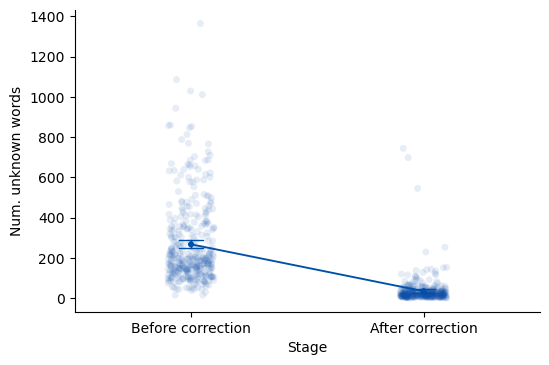

In [83]:
sns.stripplot(data = df.melt(), x = 'variable', y = 'value', alpha = 0.1, color="#1050aa", zorder=0)
sns.pointplot(data = df.melt(), x = 'variable', y = 'value', color="#0050aa", scale=0.5, zorder=1, errwidth=1, capsize=0.1)

plt.ylabel('Num. unknown words')
ticks, labels = plt.xticks()
_ = plt.xticks(ticks, labels = ["Before correction", "After correction"])
plt.xlabel("Stage")
sns.despine()

## Word counts

In [87]:
from datetime import datetime

In [88]:
data = []
for article in corpusList:
    data.append({
        'year': datetime.strptime(article.date, "%Y/%m/%d").year,
        'word count': len(article.get_bow_list())
    })
df = pd.DataFrame(data)

In [89]:
df.describe()

,year,word count
count,771.000000,771.000000
mean,2003.116732,3554.525292
std,18.889270,1376.937902
min,1951.000000,87.000000
25%,1996.000000,2586.500000
50%,2011.000000,3529.000000
75%,2017.000000,4375.500000
max,2022.000000,11048.000000


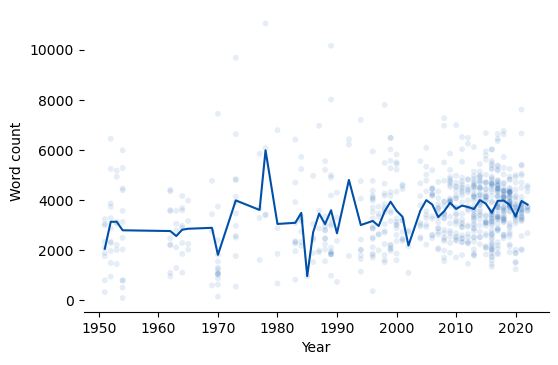

In [107]:
sns.scatterplot(data = df, x = 'year', y = 'word count', alpha = 0.1, size=0.5, legend=None, color="#0050aa")
sns.lineplot(data = df.groupby('year').mean(), legend=None, lw=1.5, palette=["#0050aa"])

plt.ylabel("Word count")
plt.xlabel("Year")
sns.despine(left=True)


In [254]:
df.groupby('year').mean()

,word count
year,
1951,2052.888889
1952,3129.000000
1953,3131.285714
1954,2790.166667
1962,2760.111111
1963,2560.200000
1964,2813.375000
1965,2851.250000
1969,2889.250000


## Articles per year

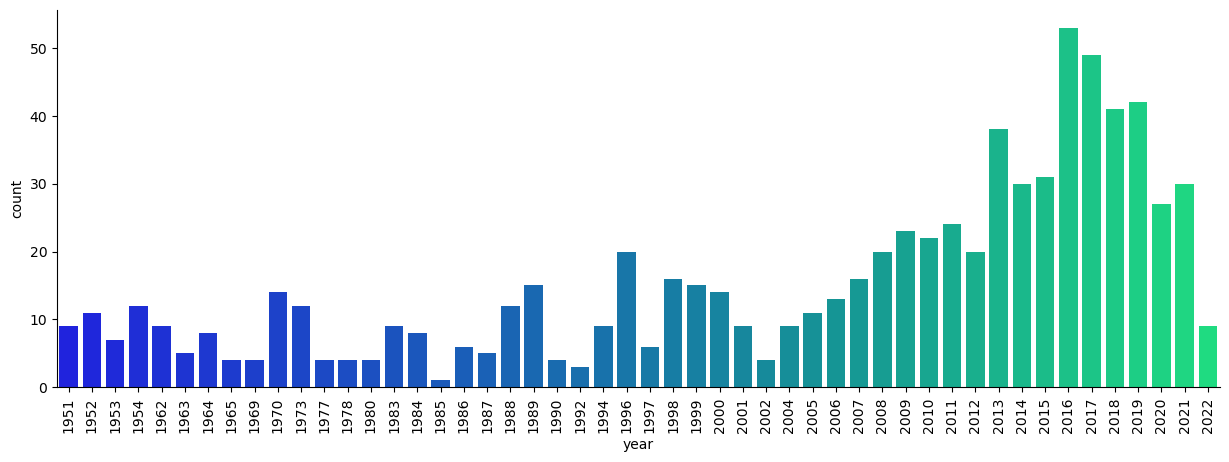

In [108]:
plt.figure(figsize = (15, 5))
sns.countplot(data = df, x = 'year', palette="winter")
_ = plt.xticks(rotation = 90)
sns.despine()

In [91]:
[f"{x}-{x+9}" for x in range(1950, 2022, 10)]

['1950-1959',
 '1960-1969',
 '1970-1979',
 '1980-1989',
 '1990-1999',
 '2000-2009',
 '2010-2019',
 '2020-2029']

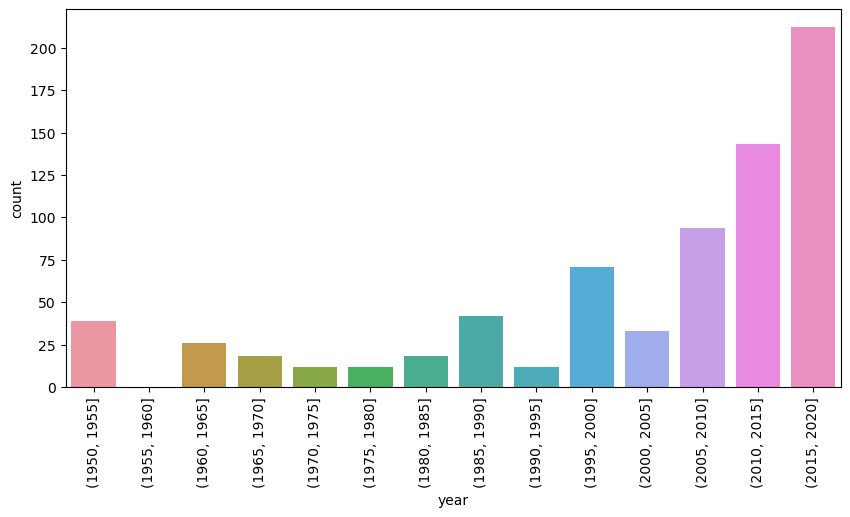

In [102]:
x = pd.cut(df['year'], bins = [x for x in range(1950, 2022, 5)])
y = df['word count']

plt.figure(figsize = (10, 5))
sns.countplot(x = x)
_ = plt.xticks(rotation = 90)

In [4]:
n_topics = 70
MODELPATH = f'models/{n_topics}_topics/LDA_gensim_{n_topics}.model'

print(MODELPATH)

models/70_topics/LDA_gensim_70.model


---

# Topic analysis

In [8]:
years = []
for topic in range(90):
    years +=[{'topic': topic, 'year': article[0].year, 'id':article[0].id} for article in get_articles_in_topic(topic, min_prob=0.5)]

In [9]:
df = pd.DataFrame(years)

In [10]:
df['year'] = df['year'].astype(int)
df['year'] = pd.cut(df['year'], bins = [x for x in range(1950, 2021, 5)])


In [11]:
yearProgression = df.groupby(['year', 'topic']).count().unstack()
yearProgression.fillna(0, inplace = True)

In [12]:
yearProgression.columns = [index[1] for index in yearProgression.columns]

In [13]:
yearProgression = yearProgression[yearProgression.columns[yearProgression.sum()>=10]]

In [14]:
#per = yearProgression.apply(lambda x: x / x.sum() * 100, axis = 1).fillna(0)
per = yearProgression

per['end'] = [x.right for x in per.index]

per.set_index('end', inplace = True)

per = per[per.index > 1970]

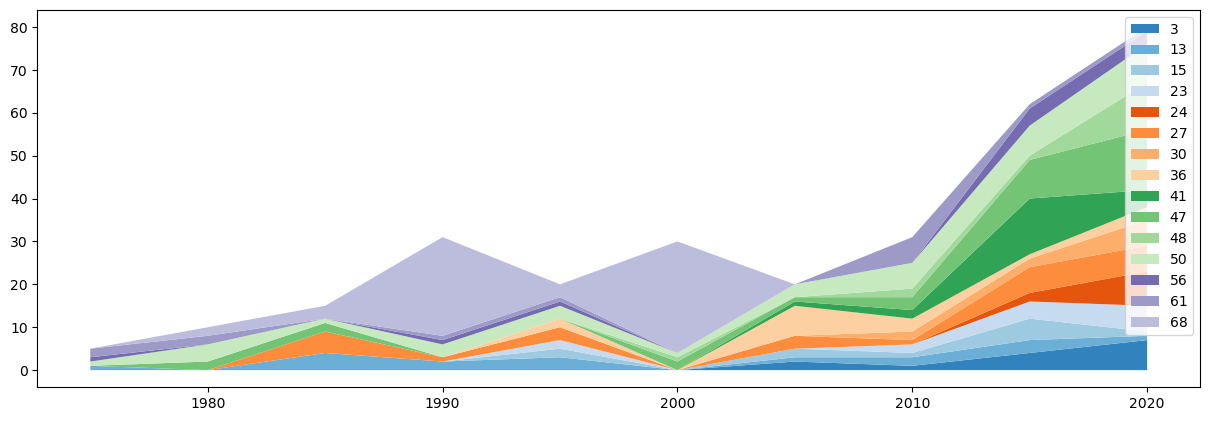

In [15]:
fig = plt.figure(figsize=(15,5))

from cycler import cycler 

colors = plt.cm.tab20c.colors

plt.gca().set_prop_cycle(cycler('color', colors))

base = 0
c = 0.01
for topic in per.iteritems():
    data = topic[1]
    
    plt.fill_between(per.index, y1 = base, y2 = base + data, label = topic[0])
    
    base += data
    c += 0.08
    
plt.legend()

---